# Market Basket Analysis

LSESU Data Science Society Project

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df_csv1 = pd.read_csv("online_retail.csv", encoding="unicode_escape") 
df_csv2 = pd.read_csv("online_retail_II.csv",  encoding="unicode_escape")
#import data from csv file
df_csv1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## Cleaning the Data

In [3]:
print(df_csv1.shape)
print(df_csv2.shape)

(541910, 8)
(525461, 8)


In [4]:
df_csv = pd.concat([df_csv1, df_csv2], axis=0)

In [5]:
df_csv.columns = df_csv.columns.str.lower().str.strip()
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [6]:
df_csv.isnull().sum() #check null values

invoice             0
stockcode           0
description      4382
quantity            0
invoicedate         0
price               0
customer id    243007
country             0
dtype: int64

In [7]:
df_csv.shape

(1067371, 8)

total rows 1067371

In [9]:
df_csv.dtypes #check columns type

invoice         object
stockcode       object
description     object
quantity         int64
invoicedate     object
price          float64
customer id    float64
country         object
dtype: object

In [10]:
df_csv["invoicedate"] = pd.to_datetime(df_csv["invoicedate"], format="%d/%m/%Y %H:%M")
df_csv.dtypes

invoice                object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
price                 float64
customer id           float64
country                object
dtype: object

In [11]:
df_csv = df_csv[df_csv["description"].notna()]
df_csv = df_csv[df_csv["quantity"] > 0]
df_csv = df_csv[df_csv["price"]> 0]
df_csv = df_csv[df_csv["country"] == "United Kingdom"]
df_csv.describe()

,quantity,price,customer id
count,958502.000000,958502.000000,725250.000000
mean,9.789489,4.021459,15559.119094
std,122.667472,51.057409,1593.844795
min,1.000000,0.001000,12346.000000
25%,1.000000,1.250000,14209.000000
50%,3.000000,2.100000,15555.000000
75%,10.000000,4.150000,16938.000000
max,80995.000000,25111.090000,18287.000000


1. Exclude price below 0
2. Exclude quantity below 0 
3. Exclude NULL descriptions

In [12]:
df_csv["description"] = df_csv["description"].str.strip()
df_csv["invoice"] = df_csv["invoice"].astype("str")
df_csv["stockcode"] = df_csv["stockcode"].astype("str")
df_csv.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
len(df_csv["description"].unique())

5327

In [14]:
df_csv[df_csv["description"].str.contains("METAL LANTERN")]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
50,536373,71053,WHITE METAL LANTERN,6,2010-12-01 09:02:00,3.39,17850.0,United Kingdom
67,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
281,536396,71053,WHITE METAL LANTERN,6,2010-12-01 10:51:00,3.39,17850.0,United Kingdom
417,536406,71053,WHITE METAL LANTERN,8,2010-12-01 11:33:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
520021,537678,71053,WHITE METAL LANTERN,24,2010-12-08 09:56:00,3.39,16779.0,United Kingdom
520360,537759,71053,WHITE METAL LANTERN,4,2010-12-08 11:42:00,3.75,13126.0,United Kingdom
521182,537811,71053,WHITE METAL LANTERN,24,2010-12-08 13:30:00,3.39,17262.0,United Kingdom
523065,538010,71053,WHITE METAL LANTERN,4,2010-12-09 12:20:00,3.75,17526.0,United Kingdom


Desctiptions might not be consistent across the same product - one evidence is shown above. Hence, Asssociation Rule Analysis made based on stockcode might be more desirable.

<AxesSubplot:>

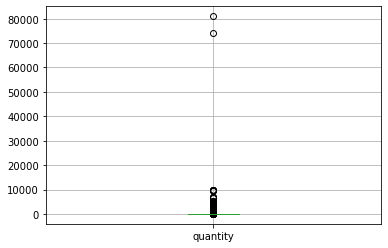

In [15]:
quantity_big = df_csv[df_csv["quantity"] > 10]
quantity_big.boxplot(column = ["quantity"])

In [16]:
bigger= quantity_big[quantity_big["quantity"] > 1000]
bigger

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
4850,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom
4945,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
4946,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
16435,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
16436,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
...,...,...,...,...,...,...,...,...
507883,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
507884,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
519373,537659,22189,CREAM HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom
519374,537659,22188,BLACK HEART CARD HOLDER,1008,2010-12-07 16:43:00,2.31,18102.0,United Kingdom


In [17]:
print(quantity_big[quantity_big["invoice"]=="581458"]["description"])
print(quantity_big[quantity_big["invoice"]=="581115"]["description"])
print(len(bigger["invoice"].unique()))

540070    POPCORN HOLDER
Name: description, dtype: object
533812    METAL SIGN TAKE IT OR LEAVE IT
Name: description, dtype: object
139


I suspect a transaction with a very high product quantity might come from a B2B business. A normal customer like you and I will not probably buy a product more than _a certain number_. We can do a rigorous statistical analysis to find _this number_ and then filter out those above it. We would be left with invoice of B2C transactions.

Most B2B transactions will only have one item in their shopping cart. 

Just realised that this based on the UCI website, the customers are mostly wholesalers.

<AxesSubplot:>

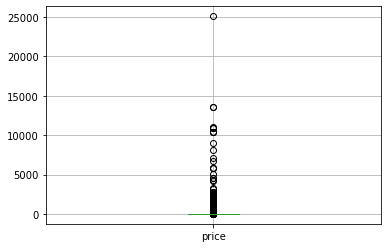

In [18]:
df_csv.boxplot(column = ["price"])

In [19]:
df_csv[df_csv["price"]>2000]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,NaN,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,NaN,United Kingdom
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.00,15581.0,United Kingdom
297725,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom
342997,566927,M,Manual,1,2011-09-15 15:20:00,2033.10,17846.0,United Kingdom
374541,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
431348,573585,DOT,DOTCOM POSTAGE,1,2011-10-31 14:41:00,2019.05,NaN,United Kingdom
493021,578149,DOT,DOTCOM POSTAGE,1,2011-11-23 11:11:00,2275.54,NaN,United Kingdom


the file does include some weird transactions. some are displayed above.So not all stockcode represent products as shown above.

In [20]:
df_csv[df_csv["invoice"] == "562946"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
297438,562946,M,Manual,1,2011-08-11 09:38:00,2500.0,15581.0,United Kingdom


1. It's ok for the quantity of a product to be high becausse it's a B2B busineess Confirm this with teamates.
2. Need to firgure out a clever way to differentiate between actual product transactions and non product transactions. 
3. Might need to think about segmenting the customers (business and actual customer)

In [33]:
non_product = ['m','gift_0001_50','gift_0001_40','gift_0001_30','gift_0001_20','gift_0001_10',"DOT", "M", "B", "POST", "AMAZONFEE", "BANK CHARGES", 'gift_0001_80',
 'gift_0001_70','TEST002','TEST001','D','C2','ADJUST2','ADJUST',  'S']

for product in non_product:
    df_csv = df_csv[df_csv["stockcode"] !=  product]

1. m: manual
2. gift: voucher
3. POST & DOT: delivery
4. B: debt
5. D: discount
6. ADJUST: Accounting adjustments
7. C2: carriage

In [34]:
print(len(df_csv["stockcode"].unique()))
sorted(list(df_csv["stockcode"].unique()), reverse=True)

4885


['SP1002',
 'PADS',
 'DCGSSGIRL',
 'DCGSSBOY',
 'DCGS0076',
 'DCGS0075',
 'DCGS0072',
 'DCGS0070',
 'DCGS0069',
 'DCGS0068',
 'DCGS0066N',
 'DCGS0062',
 'DCGS0058',
 'DCGS0044',
 'DCGS0041',
 'DCGS0037',
 'DCGS0004',
 'DCGS0003',
 '90214Z',
 '90214Y',
 '90214W',
 '90214V',
 '90214U',
 '90214T',
 '90214S',
 '90214R',
 '90214P',
 '90214O',
 '90214N',
 '90214M',
 '90214L',
 '90214K',
 '90214J',
 '90214I',
 '90214H',
 '90214G',
 '90214F',
 '90214E',
 '90214D',
 '90214C',
 '90214B',
 '90214A',
 '90212C',
 '90212B',
 '90211B',
 '90211A',
 '90210D',
 '90210C',
 '90210B',
 '90210A',
 '90209C',
 '90209B',
 '90209A',
 '90208',
 '90206C',
 '90206A',
 '90205C',
 '90205A',
 '90204',
 '90203',
 '90202D',
 '90202C',
 '90202B',
 '90202A',
 '90201D',
 '90201C',
 '90201B',
 '90201A',
 '90200E',
 '90200D',
 '90200C',
 '90200B',
 '90200A',
 '90199D',
 '90199C',
 '90199B',
 '90199A',
 '90198B',
 '90198A',
 '90197D',
 '90197B',
 '90196B',
 '90196A',
 '90195B',
 '90195A',
 '90194',
 '90192',
 '90191',
 '9019

In [36]:
df_csv[df_csv["stockcode"] == "90211A"]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
3036,536592,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2010-12-01 17:06:00,5.94,NaN,United Kingdom
13921,537434,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2010-12-06 16:57:00,5.94,NaN,United Kingdom
37060,539453,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2010-12-17 17:08:00,5.94,NaN,United Kingdom
313888,564544,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-08-25 15:50:00,5.95,15663.0,United Kingdom
436445,574149,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-11-03 11:29:00,5.95,13709.0,United Kingdom
494977,578288,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2011-11-23 14:05:00,5.95,12748.0,United Kingdom
496547,578344,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,2,2011-11-24 09:21:00,5.82,NaN,United Kingdom
529477,580730,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2011-12-05 17:28:00,5.82,NaN,United Kingdom
30574,491966,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2009-12-14 17:16:00,6.07,NaN,United Kingdom
41259,492783,90211A,DIAMOND LAS VEGAS NECKLACE 45CM,1,2009-12-18 17:15:00,6.07,NaN,United Kingdom


<AxesSubplot:>

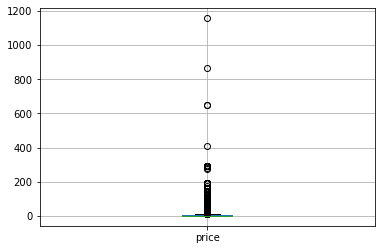

In [37]:
df_csv.boxplot(column = ["price"])

In [38]:
df_csv[df_csv["price"]>400]

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
222671,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098.0,United Kingdom
136403,502451,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-03-24 14:14:00,867.79,NaN,United Kingdom
180997,506571,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-04-30 13:04:00,408.40,NaN,United Kingdom
192196,507637,84016,FLAG OF ST GEORGE CAR FLAG,1,2010-05-10 14:55:00,1157.15,NaN,United Kingdom


In [39]:
df_csv.describe()

,quantity,price,customer id
count,955994.00000,955994.000000,724458.000000
mean,9.80261,3.372446,15559.194692
std,122.80328,4.809615,1593.732321
min,1.00000,0.001000,12346.000000
25%,1.00000,1.250000,14209.000000
50%,3.00000,2.100000,15555.000000
75%,10.00000,4.130000,16938.000000
max,80995.00000,1157.150000,18287.000000


In [102]:
df_csv.to_csv("cleaned_data.csv", index=False)

In [16]:
print(df_csv["invoicedate"].max())
print(df_csv["invoicedate"].min())

2011-12-09 12:50:00
2010-12-01 08:26:00


## Using SQL to manipulate the table

In [103]:
import sqlite3

# make sure of updating the path to a file
conn = sqlite3.connect('retail4.db')

# index = False to ensure the DataFrame row index is not written into the SQL tables
df_csv.to_sql('retail4', con = conn, index = False) 

C:\Anaconda\lib\site-packages\pandas\core\generic.py:2605: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [104]:
import sqlite3
import pandas as pd

db = 'retail2.db'

def run_query(q):
    # Connect to the database
    with sqlite3.connect(db) as conn:
        # Wrapper function to read_sql_query(): returns a DataFrame corresponding to the result set of 
        # the query string
        return pd.read_sql(q,conn)
 
# Function to show all the tables present in the database.
def show_tables():
    q = '''
        SELECT
            name
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

# Function to count how many rows in each table
def get_table_row_count(tablename):
    q = '''
        SELECT
            COUNT(1)
        FROM %s;
        ''' % tablename
    return run_query(q)["COUNT(1)"][0]

tables = show_tables()
tables["row_count"] = [get_table_row_count(t) for t in tables["name"]]

tables

,name,row_count
0,retail2,530692


In [20]:
df_csv.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer id', 'country'],
      dtype='object')

In [106]:
num_items_query = ''' 
SELECT invoice, COUNT(DISTINCT(stockcode)) "num_items", SUM(quantity) "total_quantity"
FROM retail2
GROUP BY 1
ORDER BY 2
'''
num_items = run_query(num_items_query)
num_items 

,invoice,num_items,total_quantity
0,536369,1,3
1,536371,1,80
2,536374,1,32
3,536380,1,24
4,536393,1,8
...,...,...,...
20129,558475,704,4137
20130,580729,721,2456
20131,581492,731,2011
20132,581219,749,2151


<AxesSubplot:ylabel='Frequency'>

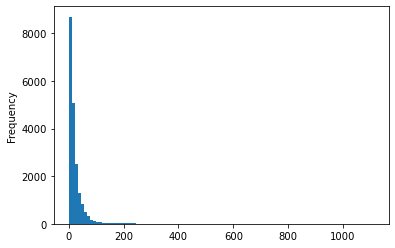

In [109]:
num_items["num_items"].plot.hist(bins=100)

In [111]:
num_items.describe()

,num_items,total_quantity
count,20134.000000,20134.000000
mean,25.834757,279.548674
std,46.835651,956.222442
min,1.000000,1.000000
25%,6.000000,68.000000
50%,15.000000,150.000000
75%,29.000000,295.000000
max,1110.000000,80995.000000


<AxesSubplot:>

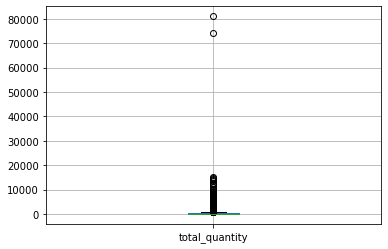

In [113]:
num_items.boxplot(column = ["total_quantity"])

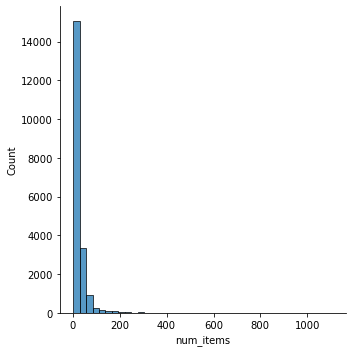

In [23]:
sns.displot(num_items["num_items"], bins=40)

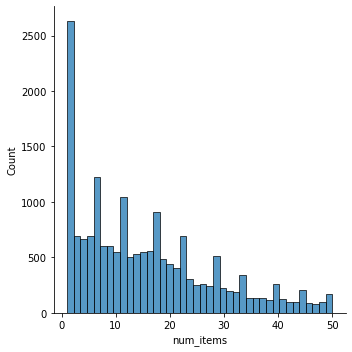

In [24]:
below_50 = num_items[num_items["num_items"] <= 50]
sns.displot(below_50["num_items"], bins=40)

In [25]:
distinct_query = '''
SELECT COUNT(DISTINCT(invoice)) "num_invoices", COUNT(DISTINCT(description)) "num_products"
FROM retail2
'''

run_query(distinct_query)

,num_invoices,num_products
0,20134,4077


In [26]:
conn.close()